nodes:  37 links  46


Population=300:   0%|          | 0/120 [00:00<?, ?it/s]

/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Completed: Pop=300, Select=0.3333333333333333, Mutate=0.3 - Fitness=1738.2826343971237
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.07 - Fitness=1879.6221583579104
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.15 - Fitness=2009.459612818403
Completed: Pop=300, Select=0.5, Mutate=0.07 - Fitness=1797.5569956366191
Completed: Pop=300, Select=0.5, Mutate=0.3 - Fitness=1804.71752701569
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.07 - Fitness=1839.6110715165082
Completed: Pop=300, Select=0.5, Mutate=0.15 - Fitness=1731.9713451899754
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.15 - Fitness=1996.090666652551
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.3 - Fitness=1747.869801437578
Completed: Pop=300, Select=0.75, Mutate=0.07 - Fitness=2078.2271815909735
Completed: Pop=300, Select=0.75, Mutate=0.15 - Fitness=2042.011618498621
Completed: Pop=300, Select=0.75, Mutate=0.3 - Fitness=1777.607045525726


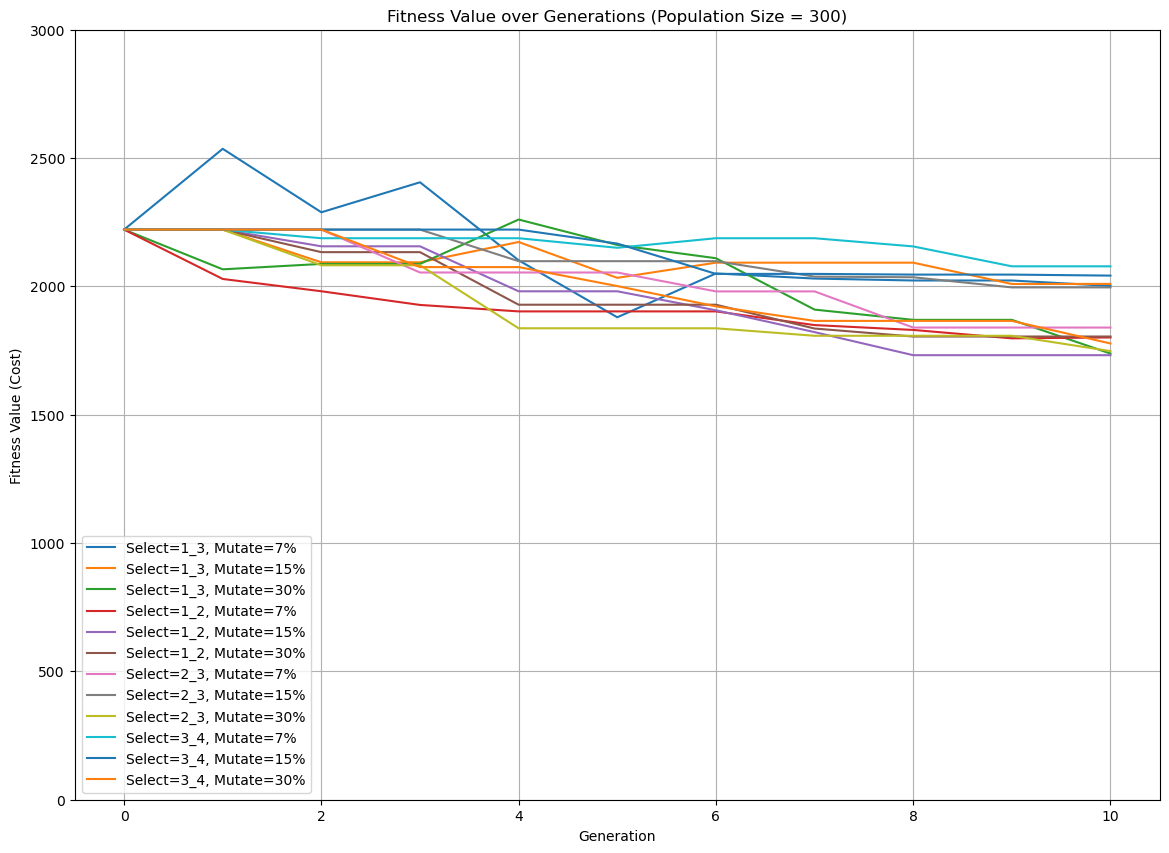

In [1]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import pickle
import os

# 读取图和位置信息
filename1 = "cost266"  # 更改为你的文件名
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 定义适应度函数
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,


# 自定义交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2


# 自定义变异操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数为文件中的边数量
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], num_edges)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 保存初始种群
def save_population(population, filename):
    with open(filename, 'wb') as f:
        pickle.dump(population, f)


# 读取初始种群
def load_population(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


# 保存遗传算法的迭代过程数据
def save_logbook(logbook, filename):
    with open(filename, 'wb') as f:
        pickle.dump(logbook, f)


# 主遗传算法流程
def main(population_size, selection_ratio, mutpb, initial_population, pbar, logbook_filename):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    num_generations = 10  # 设定总迭代次数
    cxpb = 0.5  # 交叉概率

    # 使用固定的初始种群
    pop = initial_population[:]
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)

        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]

        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring

        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)

        # 更新进度条
        pbar.update(1)

        # 更新Hall of Fame
        hof.update(pop)

    # 保存logbook到文件
    save_logbook(logbook, logbook_filename)

    return logbook, hof[0].fitness.values[0]


# 配置参数
population_sizes = [300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.05, 0.1, 0.15]

# 初始化进度条
progress_bars = {
    pop_size: tqdm(total=12 * 10, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 逐个运行每个种群大小的12种情况，并保存过程数据
for population_size in population_sizes:
    population_filename = f"./output/initial_population_{filename1}_{population_size}.pkl"
    logbook_filenames = []

    # 检查是否已有保存的初始种群文件
    if os.path.exists(population_filename):
        initial_population = load_population(population_filename)
    else:
        # 生成并保存初始种群
        initial_population = toolbox.population(n=population_size)
        save_population(initial_population, population_filename)

    # 计算初始种群的适应度并存储作为初始点
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]  # 获取最小的适应度

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size],
                            f"./output/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
                                "/", "_")): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            logbook_filename = f"./output/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
                "/", "_")
            logbook_filenames.append(logbook_filename)
            try:
                _, final_fitness = future.result()
                print(
                    f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Fitness={final_fitness}')
            except Exception as ex:
                print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')

# 完成后关闭所有进度条
for pbar in progress_bars.values():
    pbar.close()


# 读取并绘制图像
def load_logbook(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


# 统一 y 轴范围为 0 到 3000
y_min = 0
y_max = 3000


# 绘制图像
def plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness):
    plt.figure(figsize=(14, 10))
    for filename in logbook_filenames:
        logbook = load_logbook(filename)
        min_fitness_values = logbook.select("min")
        generations = list(range(1, len(min_fitness_values) + 1))
        fitness_values = [initial_fitness] + min_fitness_values  # 添加初始适应度值作为第一个点
        generations = [0] + generations  # 确保x轴从0开始

        # 获取选择率和变异率的信息来作为标签
        select_info = filename.split("_sel")[1].split("_mut")[0]
        mutate_info = filename.split("_mut")[1].split(".pkl")[0]

        plt.plot(generations, fitness_values, label=f'Select={select_info}, Mutate={mutate_info}%')

    plt.title(f"Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 设置统一的y轴范围
    plt.ylim(y_min, y_max)

    # 保存图表
    plt.savefig(f"./output/{filename1}_fitness_over_generations_population_{population_size}.png")
    plt.show()


# 读取保存的logbook文件并生成图像
for population_size in population_sizes:
    logbook_filenames = [
        f"./output/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
            "/", "_")
        for selection_ratio in selection_ratios
        for mutpb in mutation_probs
    ]

    # 计算初始种群的适应度
    initial_population = load_population(f"./output/initial_population_{filename1}_{population_size}.pkl")
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness)


nodes:  37 links  46


Population=300:   0%|          | 0/120 [00:00<?, ?it/s]

Completed: Pop=300, Select=0.3333333333333333, Mutate=0.3 - Fitness=2014.7736763101516
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.07 - Fitness=2200.3147225410507
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.15 - Fitness=1597.9853232168803
Completed: Pop=300, Select=0.5, Mutate=0.07 - Fitness=1677.9904063783968
Completed: Pop=300, Select=0.5, Mutate=0.3 - Fitness=1693.5862591275347
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.07 - Fitness=1990.1370583352023
Completed: Pop=300, Select=0.5, Mutate=0.15 - Fitness=1864.0483961165044
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.15 - Fitness=1821.6523840881414
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.3 - Fitness=1939.1880474925608
Completed: Pop=300, Select=0.75, Mutate=0.07 - Fitness=1772.439862776635
Completed: Pop=300, Select=0.75, Mutate=0.15 - Fitness=1571.4066553726068
Completed: Pop=300, Select=0.75, Mutate=0.3 - Fitness=2024.3860750854678


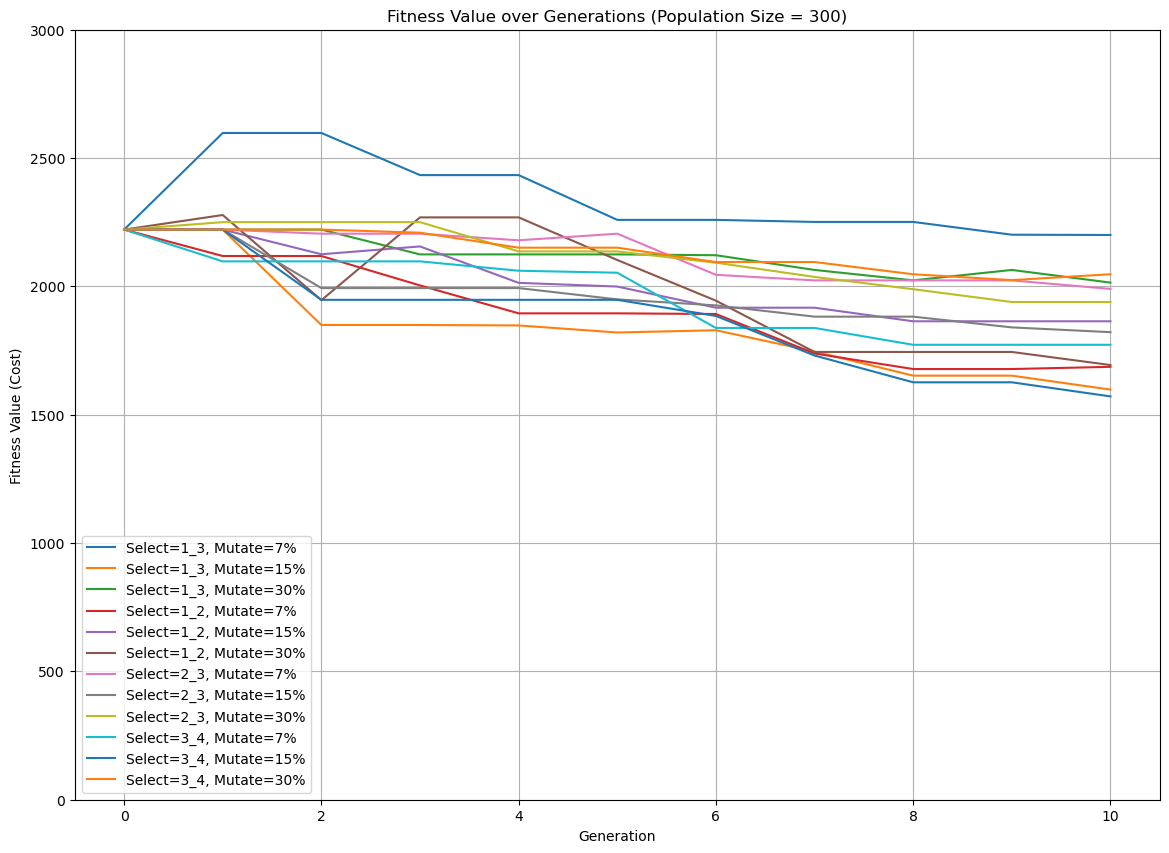

In [23]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import pickle
import os
from graph_tool.topology import min_spanning_tree

# 读取图和位置信息
filename1 = "cost266"  # 更改为你的文件名
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 定义适应度函数
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,


# 自定义交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2


# 自定义变异操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数为文件中的边数量
def initIndividual():
    num_vertices = read_graph.num_vertices()
    
    # 计算欧式距离矩阵
    edge_weights = read_graph.new_edge_property("double")
    for edge in read_graph.edges():
        source_pos = read_pos[edge.source()]
        target_pos = read_pos[edge.target()]
        euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
        edge_weights[edge] = euclidean_distance

    # 基于欧式距离生成最小生成树
    mst_edges = min_spanning_tree(read_graph, weights=edge_weights)

    # 将最小生成树中的边加入到个体中
    individual = [0] * (num_vertices * num_vertices)
    for edge in read_graph.edges():
        if mst_edges[edge]:
            source, target = int(edge.source()), int(edge.target())
            individual[source * num_vertices + target] = 1
            individual[target * num_vertices + source] = 1
    
    # 计算已经添加的边数
    mst_edge_count = sum(mst_edges.a)
    
    # 获取所有没有在最小生成树中的边
    non_mst_edges = [(int(edge.source()), int(edge.target())) for edge in read_graph.edges() if not mst_edges[edge]]
    
    # 随机添加边，直到边数与原始网络边数一致
    additional_edges_needed = num_edges - mst_edge_count
    additional_edges = random.sample(non_mst_edges, additional_edges_needed)
    
    for i, j in additional_edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    
    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 保存初始种群
def save_population(population, filename):
    with open(filename, 'wb') as f:
        pickle.dump(population, f)


# 读取初始种群
def load_population(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


# 保存遗传算法的迭代过程数据
def save_logbook(logbook, filename):
    with open(filename, 'wb') as f:
        pickle.dump(logbook, f)


# 主遗传算法流程
def main(population_size, selection_ratio, mutpb, initial_population, pbar, logbook_filename):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    num_generations = 10  # 设定总迭代次数
    cxpb = 0.5  # 交叉概率

    # 使用固定的初始种群
    pop = initial_population[:]
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)

        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]

        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring

        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)

        # 更新进度条
        pbar.update(1)

        # 更新Hall of Fame
        hof.update(pop)

    # 保存logbook到文件
    save_logbook(logbook, logbook_filename)

    return logbook, hof[0].fitness.values[0]


# 配置参数
population_sizes = [300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.05, 0.1, 0.15]

# 初始化进度条
progress_bars = {
    pop_size: tqdm(total=12 * 10, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 逐个运行每个种群大小的12种情况，并保存过程数据
for population_size in population_sizes:
    population_filename = f"./output/initial_population_{filename1}_{population_size}.pkl"
    logbook_filenames = []

    # 检查是否已有保存的初始种群文件
    if os.path.exists(population_filename):
        initial_population = load_population(population_filename)
    else:
        # 生成并保存初始种群
        initial_population = toolbox.population(n=population_size)
        save_population(initial_population, population_filename)

    # 计算初始种群的适应度并存储作为初始点
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]  # 获取最小的适应度

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size],
                            f"./output/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
                                "/", "_")): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            logbook_filename = f"./output/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
                "/", "_")
            logbook_filenames.append(logbook_filename)
            try:
                _, final_fitness = future.result()
                print(
                    f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Fitness={final_fitness}')
            except Exception as ex:
                print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')

# 完成后关闭所有进度条
for pbar in progress_bars.values():
    pbar.close()


# 读取并绘制图像
def load_logbook(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


# 统一 y 轴范围为 0 到 3000
y_min = 0
y_max = 3000


# 绘制图像
def plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness):
    plt.figure(figsize=(14, 10))
    for filename in logbook_filenames:
        logbook = load_logbook(filename)
        min_fitness_values = logbook.select("min")
        generations = list(range(1, len(min_fitness_values) + 1))
        fitness_values = [initial_fitness] + min_fitness_values  # 添加初始适应度值作为第一个点
        generations = [0] + generations  # 确保x轴从0开始

        # 获取选择率和变异率的信息来作为标签
        select_info = filename.split("_sel")[1].split("_mut")[0]
        mutate_info = filename.split("_mut")[1].split(".pkl")[0]

        plt.plot(generations, fitness_values, label=f'Select={select_info}, Mutate={mutate_info}%')

    plt.title(f"Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 设置统一的y轴范围
    plt.ylim(y_min, y_max)

    # 保存图表
    plt.savefig(f"./output/{filename1}_fitness_over_generations_population_{population_size}.png")
    plt.show()


# 读取保存的logbook文件并生成图像
for population_size in population_sizes:
    logbook_filenames = [
        f"./output/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
            "/", "_")
        for selection_ratio in selection_ratios
        for mutpb in mutation_probs
    ]

    # 计算初始种群的适应度
    initial_population = load_population(f"./output/initial_population_{filename1}_{population_size}.pkl")
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness)


nodes:  37 links  46


Population=300:   0%|          | 0/120 [00:00<?, ?it/s]

Completed: Pop=300, Select=0.3333333333333333, Mutate=0.15 - Fitness=1756.90288542312
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.1 - Fitness=1846.2593721583435
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.05 - Fitness=1853.3392321292145
Completed: Pop=300, Select=0.5, Mutate=0.05 - Fitness=1807.189613417131
Completed: Pop=300, Select=0.5, Mutate=0.1 - Fitness=1797.332009858122
Completed: Pop=300, Select=0.5, Mutate=0.15 - Fitness=1926.0048931147164
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.05 - Fitness=2063.5348507991494
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.1 - Fitness=1823.9731457268365
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.15 - Fitness=2027.3035572615033
Completed: Pop=300, Select=0.75, Mutate=0.1 - Fitness=1931.4517044407612
Completed: Pop=300, Select=0.75, Mutate=0.05 - Fitness=1781.8067320142557
Completed: Pop=300, Select=0.75, Mutate=0.15 - Fitness=1935.1916685642118


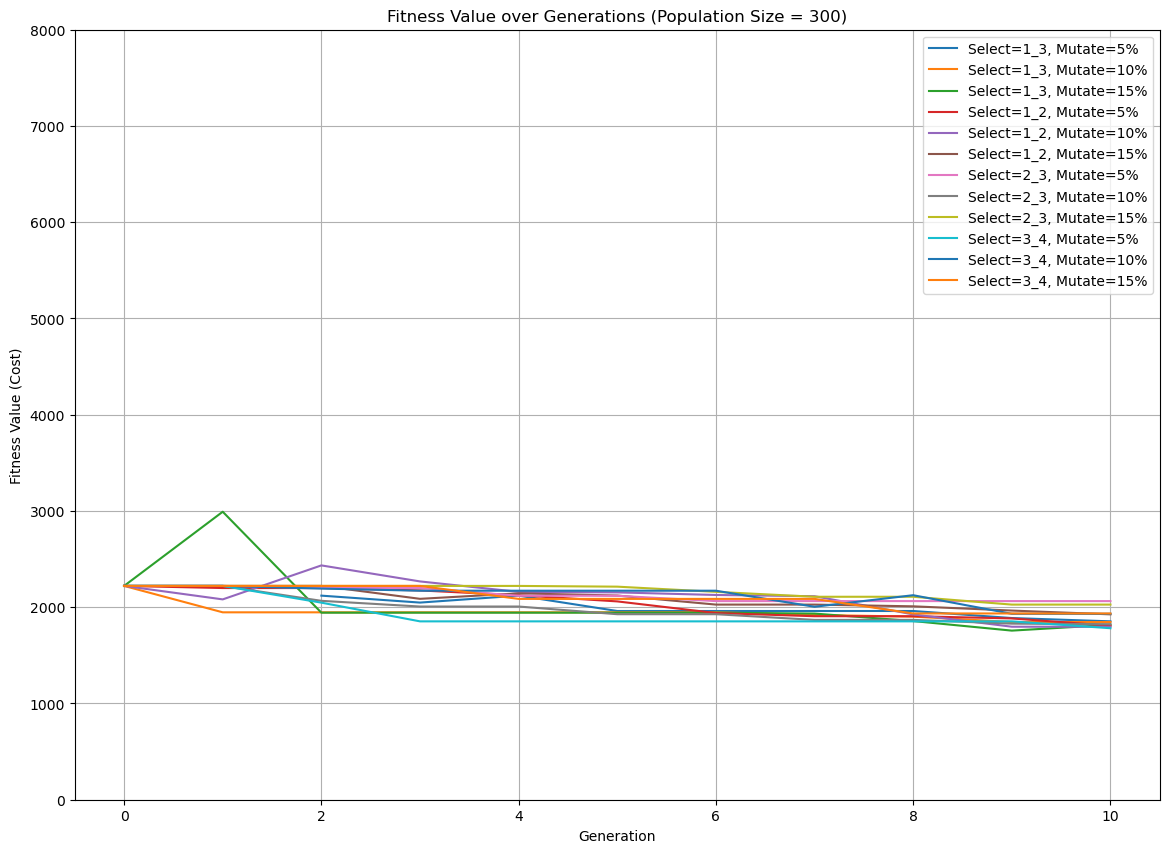

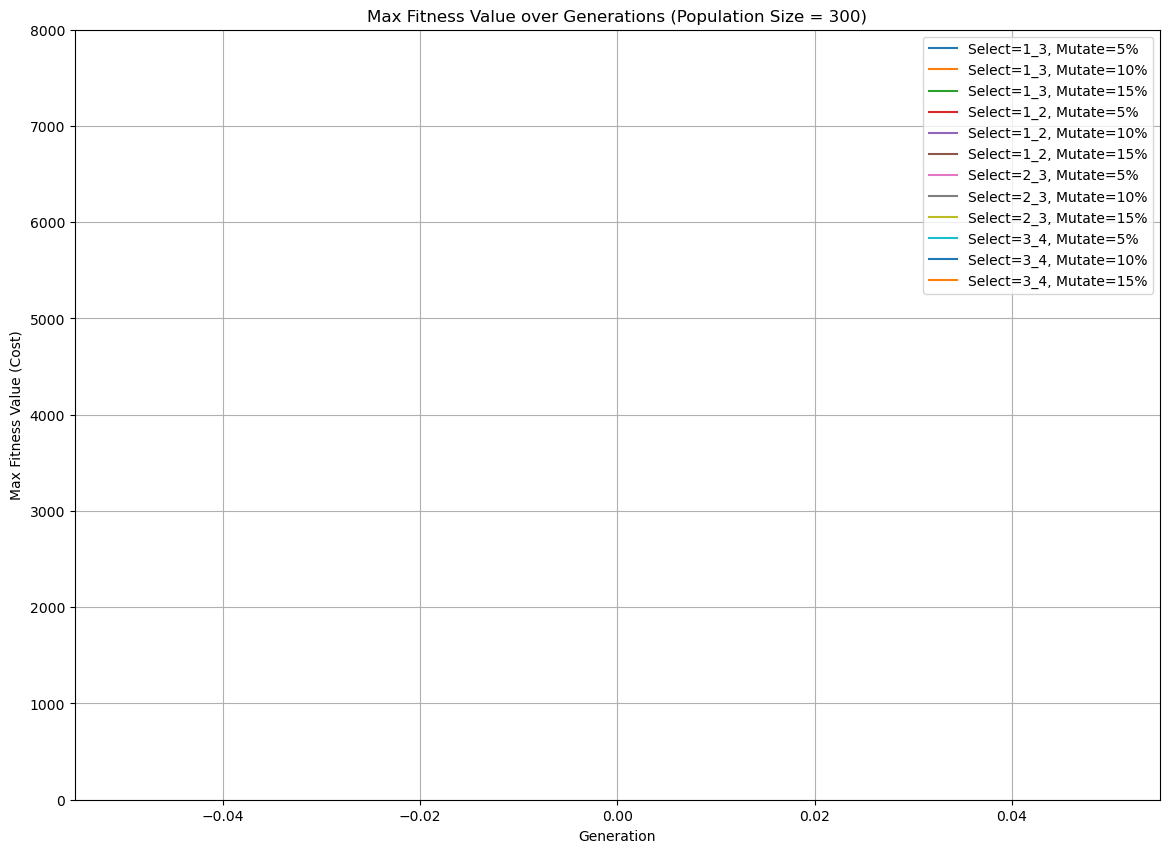

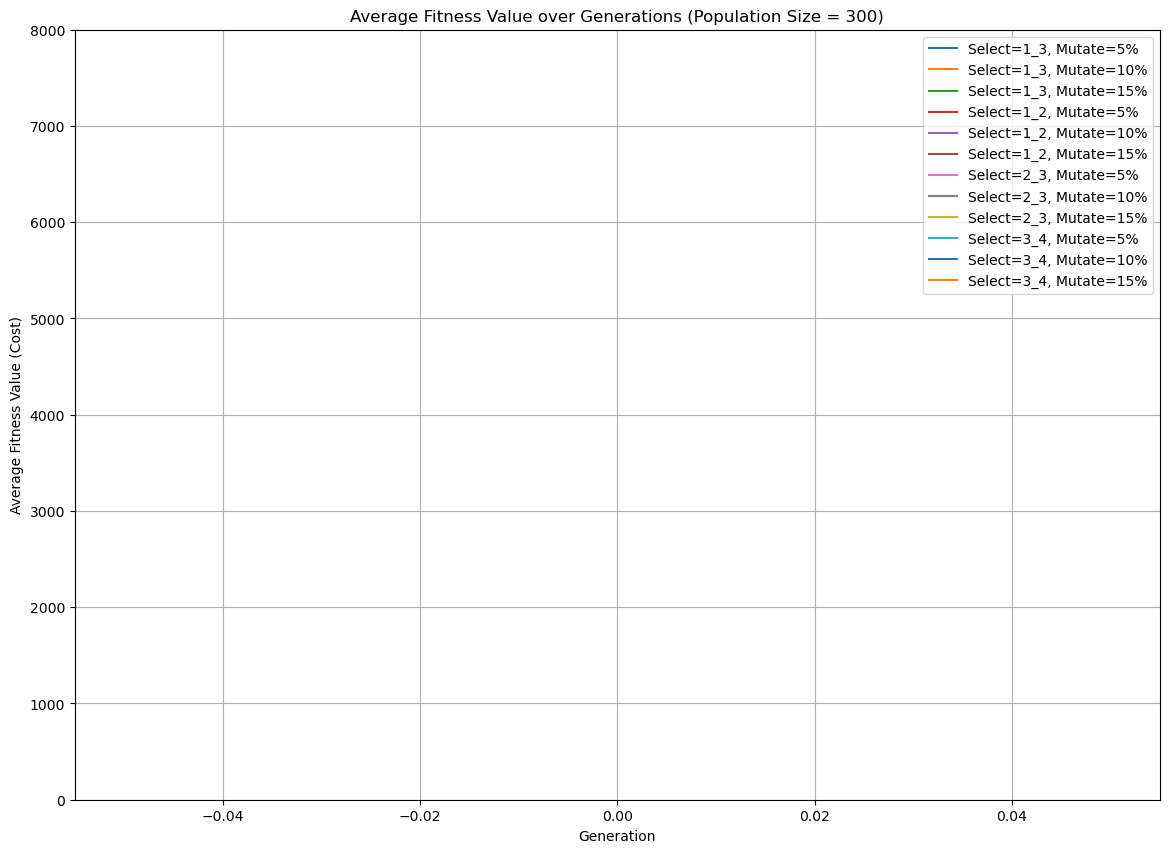

In [25]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import pickle
import os
from graph_tool.topology import min_spanning_tree

# 读取图和位置信息
filename1 = "cost266"  # 更改为你的文件名
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 定义适应度函数
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,


# 自定义交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2


# 自定义变异操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数为文件中的边数量
def initIndividual():
    num_vertices = read_graph.num_vertices()
    
    # 计算欧式距离矩阵
    edge_weights = read_graph.new_edge_property("double")
    for edge in read_graph.edges():
        source_pos = read_pos[edge.source()]
        target_pos = read_pos[edge.target()]
        euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
        edge_weights[edge] = euclidean_distance

    # 基于欧式距离生成最小生成树
    mst_edges = min_spanning_tree(read_graph, weights=edge_weights)

    # 将最小生成树中的边加入到个体中
    individual = [0] * (num_vertices * num_vertices)
    for edge in read_graph.edges():
        if mst_edges[edge]:
            source, target = int(edge.source()), int(edge.target())
            individual[source * num_vertices + target] = 1
            individual[target * num_vertices + source] = 1
    
    # 计算已经添加的边数
    mst_edge_count = sum(mst_edges.a)
    
    # 获取所有没有在最小生成树中的边
    non_mst_edges = [(int(edge.source()), int(edge.target())) for edge in read_graph.edges() if not mst_edges[edge]]
    
    # 随机添加边，直到边数与原始网络边数一致
    additional_edges_needed = num_edges - mst_edge_count
    additional_edges = random.sample(non_mst_edges, additional_edges_needed)
    
    for i, j in additional_edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    
    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 保存初始种群
def save_population(population, filename):
    with open(filename, 'wb') as f:
        pickle.dump(population, f)


# 读取初始种群
def load_population(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


# 保存遗传算法的迭代过程数据
def save_logbook(logbook, filename):
    with open(filename, 'wb') as f:
        pickle.dump(logbook, f)


# 主遗传算法流程
def main(population_size, selection_ratio, mutpb, initial_population, pbar, logbook_filename):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    num_generations = 10  # 设定总迭代次数
    cxpb = 0.5  # 交叉概率

    # 使用固定的初始种群
    pop = initial_population[:]
    hof = tools.HallOfFame(1)

    # 定义统计数据：记录最小值、最大值、平均值
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("max", np.max)
    stats.register("avg", np.mean)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min", "max", "avg"]

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)

        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]

        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring

        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 记录每一代的最小值、最大值、平均值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)

        # 更新进度条
        pbar.update(1)

        # 更新Hall of Fame
        hof.update(pop)

    # 保存logbook到文件
    save_logbook(logbook, logbook_filename)

    return logbook, hof[0].fitness.values[0]


# 配置参数
population_sizes = [300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.05, 0.1, 0.15]

# 初始化进度条
progress_bars = {
    pop_size: tqdm(total=12 * 10, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 逐个运行每个种群大小的12种情况，并保存过程数据
for population_size in population_sizes:
    population_filename = f"./output/initial_population_{filename1}_{population_size}.pkl"
    logbook_filenames = []

    # 检查是否已有保存的初始种群文件
    if os.path.exists(population_filename):
        initial_population = load_population(population_filename)
    else:
        # 生成并保存初始种群
        initial_population = toolbox.population(n=population_size)
        save_population(initial_population, population_filename)

    # 计算初始种群的适应度并存储作为初始点
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]  # 获取最小的适应度

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size],
                            f"./output/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
                                "/", "_")): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            logbook_filename = f"./output/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
                "/", "_")
            logbook_filenames.append(logbook_filename)
            try:
                _, final_fitness = future.result()
                print(
                    f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Fitness={final_fitness}')
            except Exception as ex:
                print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')

# 完成后关闭所有进度条
for pbar in progress_bars.values():
    pbar.close()


# 读取并绘制图像
def load_logbook(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


# 统一 y 轴范围为 0 到 3000
y_min = 0
y_max = 8000


# 绘制最小值图像
def plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness):
    plt.figure(figsize=(14, 10))
    for filename in logbook_filenames:
        logbook = load_logbook(filename)
        min_fitness_values = logbook.select("min")
        generations = list(range(1, len(min_fitness_values) + 1))
        fitness_values = [initial_fitness] + min_fitness_values  # 添加初始适应度值作为第一个点
        generations = [0] + generations  # 确保x轴从0开始

        # 获取选择率和变异率的信息来作为标签
        select_info = filename.split("_sel")[1].split("_mut")[0]
        mutate_info = filename.split("_mut")[1].split(".pkl")[0]

        plt.plot(generations, fitness_values, label=f'Select={select_info}, Mutate={mutate_info}%')

    plt.title(f"Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 设置统一的y轴范围
    plt.ylim(y_min, y_max)

    # 保存图表
    plt.savefig(f"./output/{filename1}_fitness_over_generations_population_{population_size}.png")
    plt.show()


# 绘制最大值图像
def plot_max_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness):
    plt.figure(figsize=(14, 10))
    for filename in logbook_filenames:
        logbook = load_logbook(filename)
        max_fitness_values = logbook.select("max")
        generations = list(range(1, len(max_fitness_values) + 1))
        fitness_values = [initial_fitness] + max_fitness_values  # 添加初始适应度值作为第一个点
        generations = [0] + generations  # 确保x轴从0开始

        # 获取选择率和变异率的信息来作为标签
        select_info = filename.split("_sel")[1].split("_mut")[0]
        mutate_info = filename.split("_mut")[1].split(".pkl")[0]

        plt.plot(generations, fitness_values, label=f'Select={select_info}, Mutate={mutate_info}%')

    plt.title(f"Max Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Max Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 设置统一的y轴范围
    plt.ylim(y_min, y_max)

    # 保存图表
    plt.savefig(f"./output/{filename1}_max_fitness_over_generations_population_{population_size}.png")
    plt.show()


# 绘制平均值图像
def plot_avg_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness):
    plt.figure(figsize=(14, 10))
    for filename in logbook_filenames:
        logbook = load_logbook(filename)
        avg_fitness_values = logbook.select("avg")
        generations = list(range(1, len(avg_fitness_values) + 1))
        fitness_values = [initial_fitness] + avg_fitness_values  # 添加初始适应度值作为第一个点
        generations = [0] + generations  # 确保x轴从0开始

        # 获取选择率和变异率的信息来作为标签
        select_info = filename.split("_sel")[1].split("_mut")[0]
        mutate_info = filename.split("_mut")[1].split(".pkl")[0]

        plt.plot(generations, fitness_values, label=f'Select={select_info}, Mutate={mutate_info}%')

    plt.title(f"Average Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Average Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 设置统一的y轴范围
    plt.ylim(y_min, y_max)

    # 保存图表
    plt.savefig(f"./output/{filename1}_avg_fitness_over_generations_population_{population_size}.png")
    plt.show()


# 读取保存的logbook文件并生成图像
for population_size in population_sizes:
    logbook_filenames = [
        f"./output/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
            "/", "_")
        for selection_ratio in selection_ratios
        for mutpb in mutation_probs
    ]

    # 计算初始种群的适应度
    initial_population = load_population(f"./output/initial_population_{filename1}_{population_size}.pkl")
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    # 绘制最小值图像
    plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness)
    
    # 绘制最大值图像
    plot_max_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness)

    # 绘制平均值图像
    plot_avg_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness)


nodes:  25 links  57


Population=300:   0%|          | 0/120 [00:00<?, ?it/s]

Completed: Pop=300, Select=0.3333333333333333, Mutate=0.15 - Fitness=363.1001966779454
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.05 - Fitness=361.2250165576882
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.1 - Fitness=358.1081233697537
Completed: Pop=300, Select=0.5, Mutate=0.05 - Fitness=361.19854853694727
Completed: Pop=300, Select=0.5, Mutate=0.1 - Fitness=357.7265610319903
Completed: Pop=300, Select=0.5, Mutate=0.15 - Fitness=358.0416304521875
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.05 - Fitness=361.2361863693325
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.1 - Fitness=366.5953158056469
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.15 - Fitness=362.923645265937
Completed: Pop=300, Select=0.75, Mutate=0.05 - Fitness=364.1003441056842
Completed: Pop=300, Select=0.75, Mutate=0.1 - Fitness=366.4409139938318
Completed: Pop=300, Select=0.75, Mutate=0.15 - Fitness=367.6776624760425


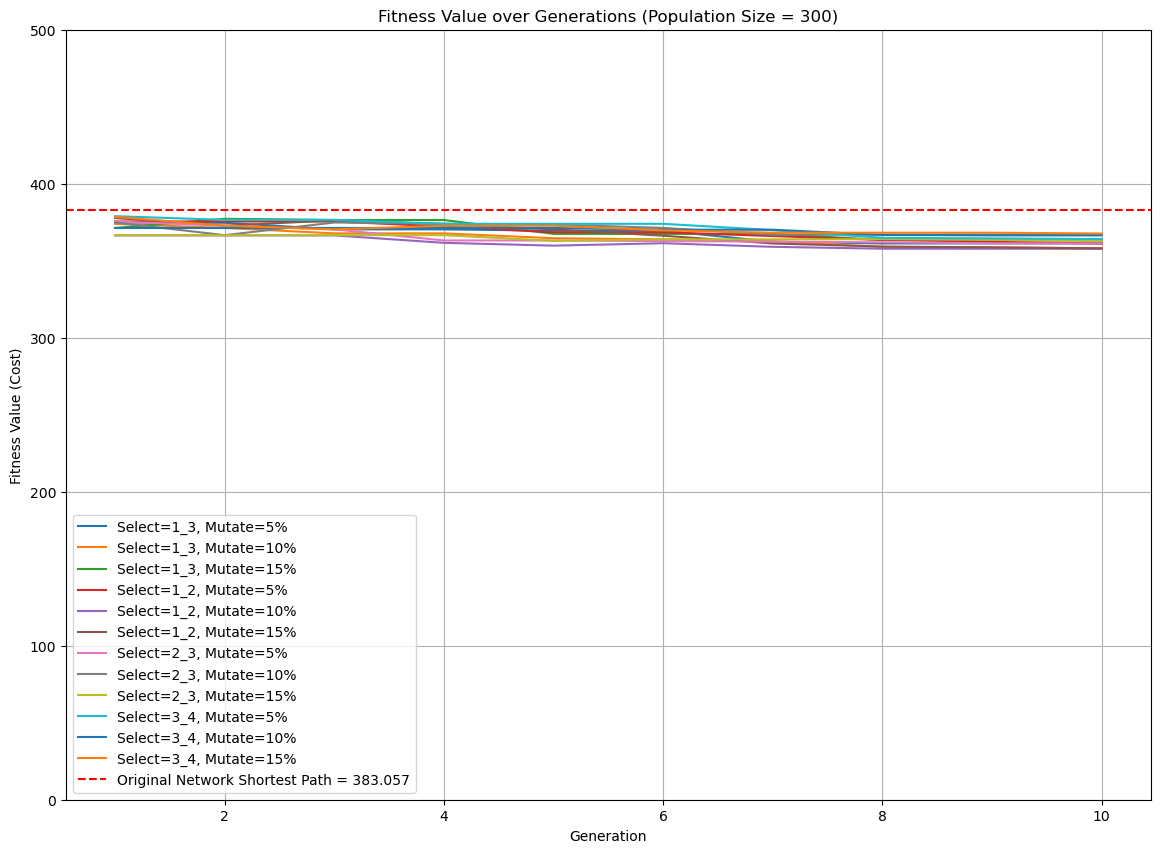

In [26]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import pickle
import os
from graph_tool.topology import min_spanning_tree

# 读取图和位置信息
filename1 = "ATT_US_Norm"  # 更改为你的文件名
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 定义适应度函数
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,


# 自定义交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2


# 自定义变异操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数为文件中的边数量
def initIndividual():
    num_vertices = read_graph.num_vertices()

    # 计算欧式距离矩阵
    edge_weights = read_graph.new_edge_property("double")
    for edge in read_graph.edges():
        source_pos = read_pos[edge.source()]
        target_pos = read_pos[edge.target()]
        euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
        edge_weights[edge] = euclidean_distance

    # 基于欧式距离生成最小生成树
    mst_edges = min_spanning_tree(read_graph, weights=edge_weights)

    # 将最小生成树中的边加入到个体中
    individual = [0] * (num_vertices * num_vertices)
    for edge in read_graph.edges():
        if mst_edges[edge]:
            source, target = int(edge.source()), int(edge.target())
            individual[source * num_vertices + target] = 1
            individual[target * num_vertices + source] = 1

    # 计算已经添加的边数
    mst_edge_count = sum(mst_edges.a)

    # 获取所有没有在最小生成树中的边
    non_mst_edges = [(int(edge.source()), int(edge.target())) for edge in read_graph.edges() if not mst_edges[edge]]

    # 随机添加边，直到边数与原始网络边数一致
    additional_edges_needed = num_edges - mst_edge_count
    additional_edges = random.sample(non_mst_edges, additional_edges_needed)

    for i, j in additional_edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1

    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 保存初始种群
def save_population(population, filename):
    with open(filename, 'wb') as f:
        pickle.dump(population, f)


# 读取初始种群
def load_population(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


# 保存遗传算法的迭代过程数据
def save_logbook(logbook, filename):
    with open(filename, 'wb') as f:
        pickle.dump(logbook, f)


# 主遗传算法流程
def main(population_size, selection_ratio, mutpb, initial_population, pbar, logbook_filename):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    num_generations = 10  # 设定总迭代次数
    cxpb = 0.5  # 交叉概率

    # 使用固定的初始种群
    pop = initial_population[:]
    hof = tools.HallOfFame(1)

    # 定义统计数据：记录最小值
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)

        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]

        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring

        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 记录每一代的最小值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)

        # 更新进度条
        pbar.update(1)

        # 更新Hall of Fame
        hof.update(pop)

    # 保存logbook到文件
    save_logbook(logbook, logbook_filename)

    return logbook, hof[0].fitness.values[0]


# 配置参数
population_sizes = [300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.05, 0.1, 0.15]

# 初始化进度条
progress_bars = {
    pop_size: tqdm(total=12 * 10, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 逐个运行每个种群大小的12种情况，并保存过程数据
for population_size in population_sizes:
    population_filename = f"./output/initial_population_{filename1}_{population_size}.pkl"
    logbook_filenames = []

    # 检查是否已有保存的初始种群文件
    if os.path.exists(population_filename):
        initial_population = load_population(population_filename)
    else:
        # 生成并保存初始种群
        initial_population = toolbox.population(n=population_size)
        save_population(initial_population, population_filename)

    # 计算初始种群的适应度并存储作为初始点
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]  # 获取最小的适应度

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size],
                            f"./output/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
                                "/", "_")): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            logbook_filename = f"./output/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
                "/", "_")
            logbook_filenames.append(logbook_filename)
            try:
                _, final_fitness = future.result()
                print(
                    f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Fitness={final_fitness}')
            except Exception as ex:
                print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')

# 完成后关闭所有进度条
for pbar in progress_bars.values():
    pbar.close()


# 读取并绘制图像
def load_logbook(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


# 统一 y 轴范围为 0 到 500
y_min = 0
y_max = 500
original_network_value = 383.057  # 原始网络的最短路径和


# 绘制最小值图像，并在 y=383.057 处添加一条虚线
def plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness, original_value):
    plt.figure(figsize=(14, 10))
    for filename in logbook_filenames:
        logbook = load_logbook(filename)
        min_fitness_values = logbook.select("min")
        generations = list(range(1, len(min_fitness_values) + 1))
        fitness_values = [initial_fitness] + min_fitness_values  # 添加初始适应度值作为第一个点
        generations = [0] + generations  # 确保x轴从0开始

        # 获取选择率和变异率的信息来作为标签
        select_info = filename.split("_sel")[1].split("_mut")[0]
        mutate_info = filename.split("_mut")[1].split(".pkl")[0]

        # 绘制每条曲线
        plt.plot(generations, fitness_values, label=f'Select={select_info}, Mutate={mutate_info}%')

    # 在 y=383.057 处添加一条虚线
    plt.axhline(y=original_value, color='r', linestyle='--', label=f'Original Network Shortest Path = {original_value}')

    plt.title(f"Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 设置统一的y轴范围
    plt.ylim(y_min, y_max)

    # 保存图表
    plt.savefig(f"./output/{filename1}_fitness_over_generations_population_{population_size}.png")
    plt.show()


# 读取保存的logbook文件并生成图像
for population_size in population_sizes:
    logbook_filenames = [
        f"./output/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
            "/", "_")
        for selection_ratio in selection_ratios
        for mutpb in mutation_probs
    ]

    # 计算初始种群的适应度
    initial_population = load_population(f"./output/initial_population_{filename1}_{population_size}.pkl")
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    # 绘制最小值图像
    plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness,
                                  original_network_value)


nodes:  50 links  69


Population=300:   0%|          | 0/1200 [00:00<?, ?it/s]

Completed: Pop=300, Select=0.3333333333333333, Mutate=0.05 - Fitness=1460.7993522066972
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.15 - Fitness=1461.9424379253092
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.1 - Fitness=1458.351219960764
Completed: Pop=300, Select=0.5, Mutate=0.05 - Fitness=1454.9666596000206
Completed: Pop=300, Select=0.5, Mutate=0.1 - Fitness=1451.0934704480537
Completed: Pop=300, Select=0.5, Mutate=0.15 - Fitness=1417.6251635693723
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.05 - Fitness=1441.3717412544245
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.1 - Fitness=1456.8845177516764
Completed: Pop=300, Select=0.75, Mutate=0.05 - Fitness=1448.6109022719872
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.15 - Fitness=1448.8435970945454
Completed: Pop=300, Select=0.75, Mutate=0.1 - Fitness=1475.4567677637797
Completed: Pop=300, Select=0.75, Mutate=0.15 - Fitness=1424.2585871990964


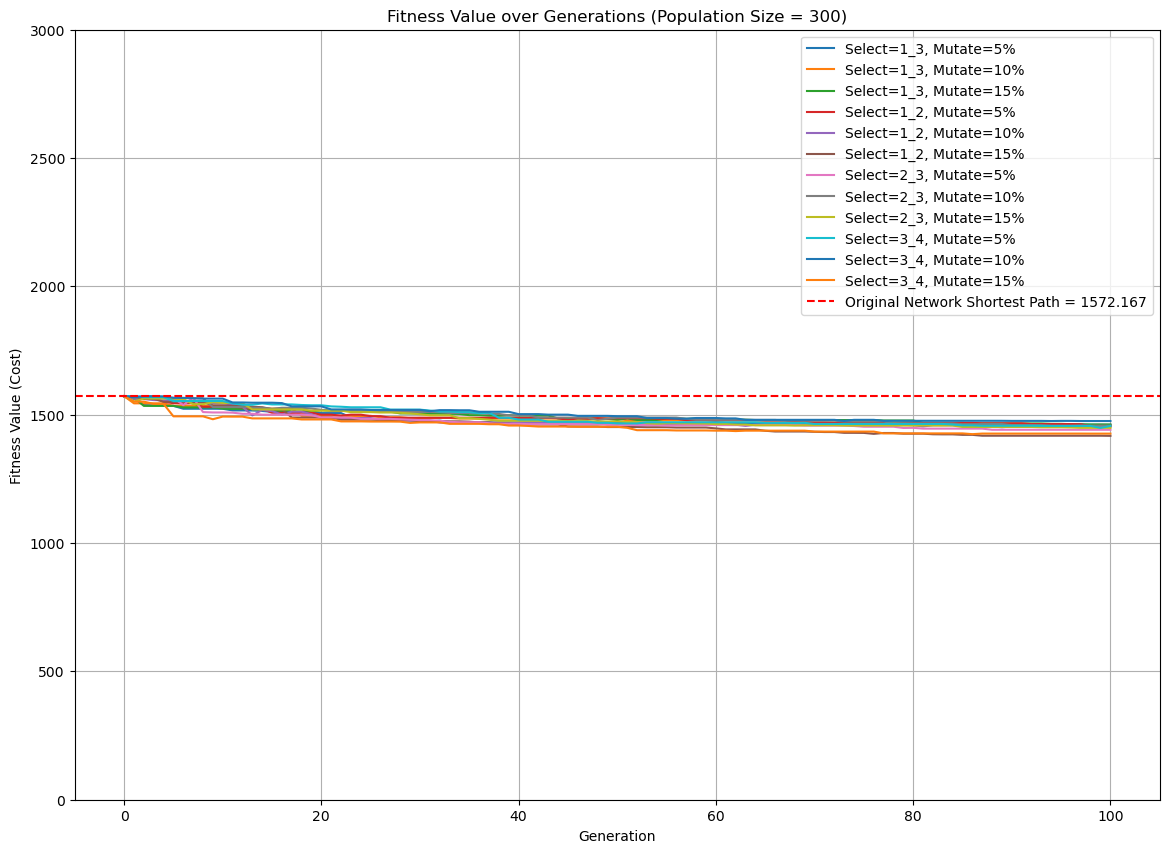

In [28]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import pickle
import os
from graph_tool.topology import min_spanning_tree

# 读取图和位置信息
filename1 = "Germany50"  # 更改为你的文件名
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 定义适应度函数
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,


# 自定义交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2


# 自定义变异操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数为文件中的边数量
def initIndividual():
    num_vertices = read_graph.num_vertices()

    # 计算欧式距离矩阵
    edge_weights = read_graph.new_edge_property("double")
    for edge in read_graph.edges():
        source_pos = read_pos[edge.source()]
        target_pos = read_pos[edge.target()]
        euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
        edge_weights[edge] = euclidean_distance

    # 基于欧式距离生成最小生成树
    mst_edges = min_spanning_tree(read_graph, weights=edge_weights)

    # 将最小生成树中的边加入到个体中
    individual = [0] * (num_vertices * num_vertices)
    for edge in read_graph.edges():
        if mst_edges[edge]:
            source, target = int(edge.source()), int(edge.target())
            individual[source * num_vertices + target] = 1
            individual[target * num_vertices + source] = 1

    # 计算已经添加的边数
    mst_edge_count = sum(mst_edges.a)

    # 获取所有没有在最小生成树中的边
    non_mst_edges = [(int(edge.source()), int(edge.target())) for edge in read_graph.edges() if not mst_edges[edge]]

    # 随机添加边，直到边数与原始网络边数一致
    additional_edges_needed = num_edges - mst_edge_count
    additional_edges = random.sample(non_mst_edges, additional_edges_needed)

    for i, j in additional_edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1

    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 保存初始种群
def save_population(population, filename):
    with open(filename, 'wb') as f:
        pickle.dump(population, f)


# 读取初始种群
def load_population(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


# 保存遗传算法的迭代过程数据
def save_logbook(logbook, filename):
    with open(filename, 'wb') as f:
        pickle.dump(logbook, f)


# 主遗传算法流程
def main(population_size, selection_ratio, mutpb, initial_population, pbar, logbook_filename):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    num_generations = 100  # 设定总迭代次数
    cxpb = 0.5  # 交叉概率

    # 使用固定的初始种群
    pop = initial_population[:]
    hof = tools.HallOfFame(1)

    # 定义统计数据：记录最小值
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)

        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]

        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring

        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 记录每一代的最小值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)

        # 更新进度条
        pbar.update(1)

        # 更新Hall of Fame
        hof.update(pop)

    # 保存logbook到文件
    save_logbook(logbook, logbook_filename)

    return logbook, hof[0].fitness.values[0]


# 配置参数
population_sizes = [300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.05, 0.1, 0.15]

# 初始化进度条
progress_bars = {
    pop_size: tqdm(total=12 * 100, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 逐个运行每个种群大小的12种情况，并保存过程数据
for population_size in population_sizes:
    population_filename = f"./output/initial_population_{filename1}_{population_size}.pkl"
    logbook_filenames = []

    # 检查是否已有保存的初始种群文件
    if os.path.exists(population_filename):
        initial_population = load_population(population_filename)
    else:
        # 生成并保存初始种群
        initial_population = toolbox.population(n=population_size)
        save_population(initial_population, population_filename)

    # 计算初始种群的适应度并存储作为初始点
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]  # 获取最小的适应度

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size],
                            f"./output/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
                                "/", "_")): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            logbook_filename = f"./output/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
                "/", "_")
            logbook_filenames.append(logbook_filename)
            try:
                _, final_fitness = future.result()
                print(
                    f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Fitness={final_fitness}')
            except Exception as ex:
                print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')

# 完成后关闭所有进度条
for pbar in progress_bars.values():
    pbar.close()


# 读取并绘制图像
def load_logbook(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


# 统一 y 轴范围为 0 到 500
y_min = 0
y_max = 3000
original_network_value = 1572.167  # 原始网络的最短路径和


# 绘制最小值图像，并在 y=383.057 处添加一条虚线
def plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness, original_value):
    plt.figure(figsize=(14, 10))
    for filename in logbook_filenames:
        logbook = load_logbook(filename)
        min_fitness_values = logbook.select("min")
        generations = list(range(1, len(min_fitness_values) + 1))
        fitness_values = [initial_fitness] + min_fitness_values  # 添加初始适应度值作为第一个点
        generations = [0] + generations  # 确保x轴从0开始

        # 获取选择率和变异率的信息来作为标签
        select_info = filename.split("_sel")[1].split("_mut")[0]
        mutate_info = filename.split("_mut")[1].split(".pkl")[0]

        # 绘制每条曲线
        plt.plot(generations, fitness_values, label=f'Select={select_info}, Mutate={mutate_info}%')

    # 在 y=383.057 处添加一条虚线
    plt.axhline(y=original_value, color='r', linestyle='--', label=f'Original Network Shortest Path = {original_value}')

    plt.title(f"Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 设置统一的y轴范围
    plt.ylim(y_min, y_max)

    # 保存图表
    plt.savefig(f"./output/{filename1}_fitness_over_generations_population_{population_size}.png")
    plt.show()


# 读取保存的logbook文件并生成图像
for population_size in population_sizes:
    logbook_filenames = [
        f"./output/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
            "/", "_")
        for selection_ratio in selection_ratios
        for mutpb in mutation_probs
    ]

    # 计算初始种群的适应度
    initial_population = load_population(f"./output/initial_population_{filename1}_{population_size}.pkl")
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    # 绘制最小值图像
    plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness,
                                  original_network_value)


nodes:  50 links  69


Population=300:   0%|          | 0/12000 [00:00<?, ?it/s]

Completed: Pop=300, Select=0.3333333333333333, Mutate=0.15 - Fitness=1388.0991745131182
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.1 - Fitness=1391.1147056325608
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.05 - Fitness=1402.4220516795808
Completed: Pop=300, Select=0.5, Mutate=0.05 - Fitness=1394.023830839776
Completed: Pop=300, Select=0.5, Mutate=0.1 - Fitness=1374.9616986666406
Completed: Pop=300, Select=0.5, Mutate=0.15 - Fitness=1384.6776120483296
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.05 - Fitness=1410.7785772291923
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.1 - Fitness=1396.029902617415
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.15 - Fitness=1389.1830977191878
Completed: Pop=300, Select=0.75, Mutate=0.05 - Fitness=1391.7088231464436
Completed: Pop=300, Select=0.75, Mutate=0.1 - Fitness=1400.9943217869893
Completed: Pop=300, Select=0.75, Mutate=0.15 - Fitness=1388.6442269896033


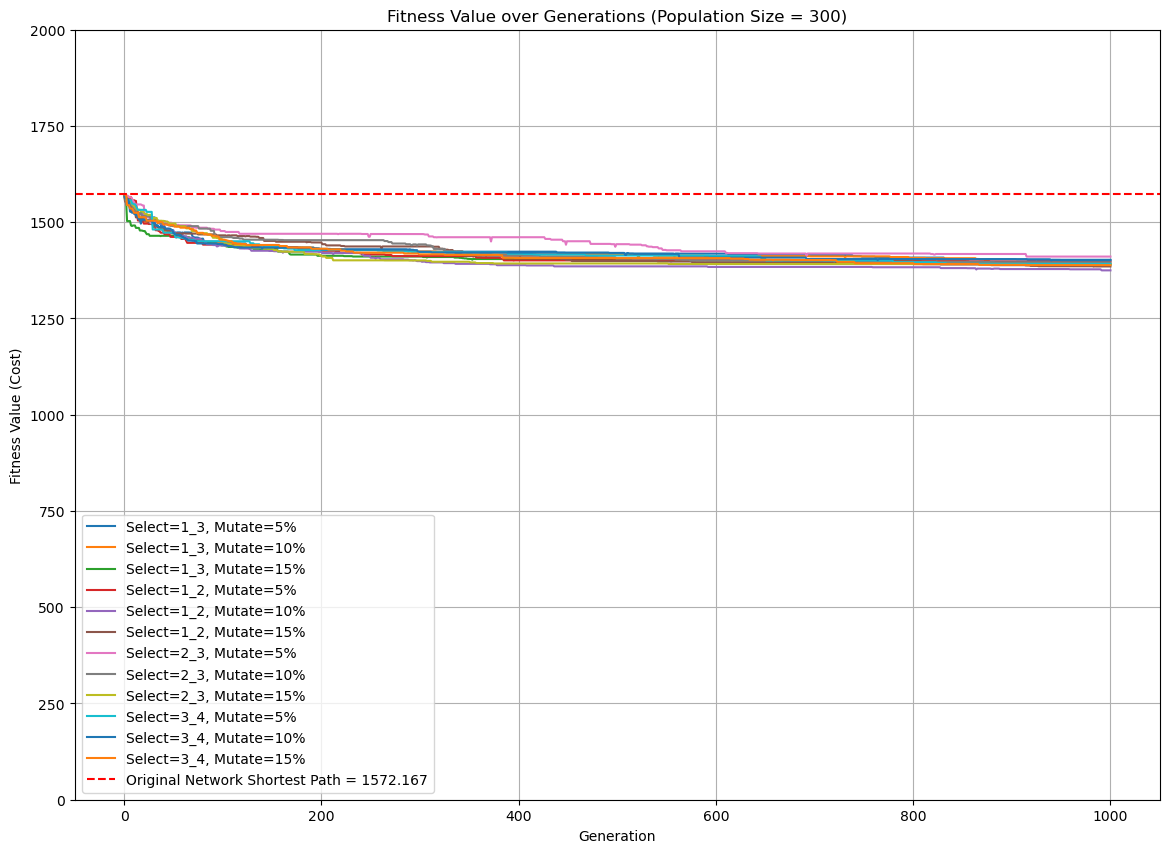

In [29]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import pickle
import os
from graph_tool.topology import min_spanning_tree

# 读取图和位置信息
filename1 = "Germany50"  # 更改为你的文件名
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 定义适应度函数
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,


# 自定义交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2


# 自定义变异操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数为文件中的边数量
def initIndividual():
    num_vertices = read_graph.num_vertices()

    # 计算欧式距离矩阵
    edge_weights = read_graph.new_edge_property("double")
    for edge in read_graph.edges():
        source_pos = read_pos[edge.source()]
        target_pos = read_pos[edge.target()]
        euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
        edge_weights[edge] = euclidean_distance

    # 基于欧式距离生成最小生成树
    mst_edges = min_spanning_tree(read_graph, weights=edge_weights)

    # 将最小生成树中的边加入到个体中
    individual = [0] * (num_vertices * num_vertices)
    for edge in read_graph.edges():
        if mst_edges[edge]:
            source, target = int(edge.source()), int(edge.target())
            individual[source * num_vertices + target] = 1
            individual[target * num_vertices + source] = 1

    # 计算已经添加的边数
    mst_edge_count = sum(mst_edges.a)

    # 获取所有没有在最小生成树中的边
    non_mst_edges = [(int(edge.source()), int(edge.target())) for edge in read_graph.edges() if not mst_edges[edge]]

    # 随机添加边，直到边数与原始网络边数一致
    additional_edges_needed = num_edges - mst_edge_count
    additional_edges = random.sample(non_mst_edges, additional_edges_needed)

    for i, j in additional_edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1

    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 保存初始种群
def save_population(population, filename):
    with open(filename, 'wb') as f:
        pickle.dump(population, f)


# 读取初始种群
def load_population(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


# 保存遗传算法的迭代过程数据
def save_logbook(logbook, filename):
    with open(filename, 'wb') as f:
        pickle.dump(logbook, f)


# 主遗传算法流程
def main(population_size, selection_ratio, mutpb, initial_population, pbar, logbook_filename):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    num_generations = 1000  # 设定总迭代次数
    cxpb = 0.5  # 交叉概率

    # 使用固定的初始种群
    pop = initial_population[:]
    hof = tools.HallOfFame(1)

    # 定义统计数据：记录最小值
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)

        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]

        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring

        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 记录每一代的最小值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)

        # 更新进度条
        pbar.update(1)

        # 更新Hall of Fame
        hof.update(pop)

    # 保存logbook到文件
    save_logbook(logbook, logbook_filename)

    return logbook, hof[0].fitness.values[0]


# 配置参数
population_sizes = [300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.05, 0.1, 0.15]

# 初始化进度条
progress_bars = {
    pop_size: tqdm(total=12 * 1000, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 逐个运行每个种群大小的12种情况，并保存过程数据
for population_size in population_sizes:
    population_filename = f"./output/initial_population_{filename1}_{population_size}.pkl"
    logbook_filenames = []

    # 检查是否已有保存的初始种群文件
    if os.path.exists(population_filename):
        initial_population = load_population(population_filename)
    else:
        # 生成并保存初始种群
        initial_population = toolbox.population(n=population_size)
        save_population(initial_population, population_filename)

    # 计算初始种群的适应度并存储作为初始点
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]  # 获取最小的适应度

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size],
                            f"./output/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
                                "/", "_")): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            logbook_filename = f"./output/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
                "/", "_")
            logbook_filenames.append(logbook_filename)
            try:
                _, final_fitness = future.result()
                print(
                    f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Fitness={final_fitness}')
            except Exception as ex:
                print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')

# 完成后关闭所有进度条
for pbar in progress_bars.values():
    pbar.close()


# 读取并绘制图像
def load_logbook(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


# 统一 y 轴范围为 0 到 500
y_min = 0
y_max = 2000
original_network_value = 1572.167  # 原始网络的最短路径和


# 绘制最小值图像，并在 y=383.057 处添加一条虚线
def plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness, original_value):
    plt.figure(figsize=(14, 10))
    for filename in logbook_filenames:
        logbook = load_logbook(filename)
        min_fitness_values = logbook.select("min")
        generations = list(range(1, len(min_fitness_values) + 1))
        fitness_values = [initial_fitness] + min_fitness_values  # 添加初始适应度值作为第一个点
        generations = [0] + generations  # 确保x轴从0开始

        # 获取选择率和变异率的信息来作为标签
        select_info = filename.split("_sel")[1].split("_mut")[0]
        mutate_info = filename.split("_mut")[1].split(".pkl")[0]

        # 绘制每条曲线
        plt.plot(generations, fitness_values, label=f'Select={select_info}, Mutate={mutate_info}%')

    # 在 y=383.057 处添加一条虚线
    plt.axhline(y=original_value, color='r', linestyle='--', label=f'Original Network Shortest Path = {original_value}')

    plt.title(f"Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 设置统一的y轴范围
    plt.ylim(y_min, y_max)

    # 保存图表
    plt.savefig(f"./output/2{filename1}_fitness_over_generations_population_{population_size}.png")
    plt.show()


# 读取保存的logbook文件并生成图像
for population_size in population_sizes:
    logbook_filenames = [
        f"./output/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
            "/", "_")
        for selection_ratio in selection_ratios
        for mutpb in mutation_probs
    ]

    # 计算初始种群的适应度
    initial_population = load_population(f"./output/initial_population_{filename1}_{population_size}.pkl")
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    # 绘制最小值图像
    plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness,
                                  original_network_value)


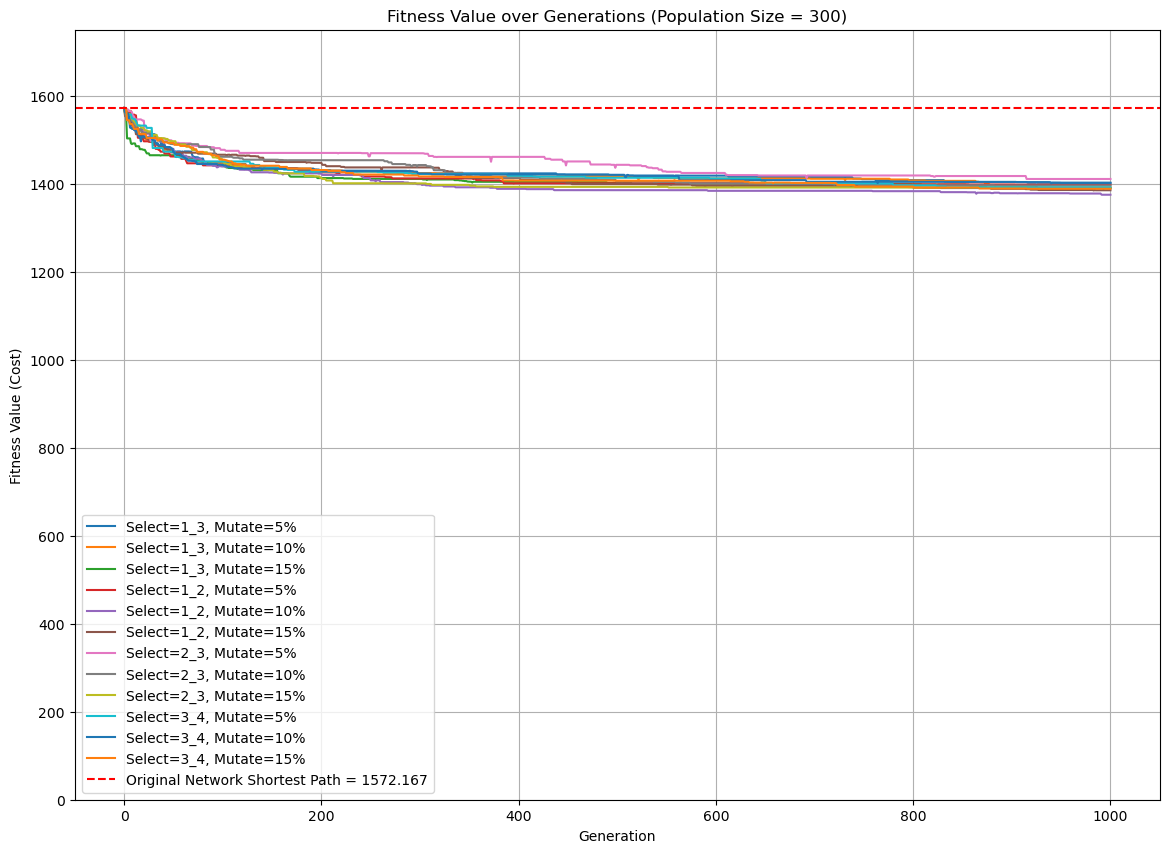

In [32]:
def load_logbook(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


# 统一 y 轴范围为 0 到 500
y_min = 0
y_max = 1750
original_network_value = 1572.167  # 原始网络的最短路径和


# 绘制最小值图像，并在 y=383.057 处添加一条虚线
def plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness, original_value):
    plt.figure(figsize=(14, 10))
    for filename in logbook_filenames:
        logbook = load_logbook(filename)
        min_fitness_values = logbook.select("min")
        generations = list(range(1, len(min_fitness_values) + 1))
        fitness_values = [initial_fitness] + min_fitness_values  # 添加初始适应度值作为第一个点
        generations = [0] + generations  # 确保x轴从0开始

        # 获取选择率和变异率的信息来作为标签
        select_info = filename.split("_sel")[1].split("_mut")[0]
        mutate_info = filename.split("_mut")[1].split(".pkl")[0]

        # 绘制每条曲线
        plt.plot(generations, fitness_values, label=f'Select={select_info}, Mutate={mutate_info}%')

    # 在 y=383.057 处添加一条虚线
    plt.axhline(y=original_value, color='r', linestyle='--', label=f'Original Network Shortest Path = {original_value}')

    plt.title(f"Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 设置统一的y轴范围
    plt.ylim(y_min, y_max)

    # 保存图表
    plt.savefig(f"./output/3.0{filename1}_fitness_over_generations_population_{population_size}.png")
    plt.show()


# 读取保存的logbook文件并生成图像
for population_size in population_sizes:
    logbook_filenames = [
        f"./output/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
            "/", "_")
        for selection_ratio in selection_ratios
        for mutpb in mutation_probs
    ]

    # 计算初始种群的适应度
    initial_population = load_population(f"./output/initial_population_{filename1}_{population_size}.pkl")
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    # 绘制最小值图像
    plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness,
                                  original_network_value)
